### We will be using Feature Extraction method for transfer learning

In [1]:
#  Instantiating the VGG16 convolutional base
from keras.applications import VGG16

In [2]:
conv_base = VGG16(weights="imagenet",
                  include_top=False,
                  input_shape=(256,256,3))

58889256/58889256 [==============================] - 2s 0us/step


In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

- The final feature map has shape (8, 8, 512). That's the feature on top of which we will stick a densely connected classifier.

### At this point, there are two ways:
- Running the convolutional base over our dataset, recording its output to a Numpy array on disk, and then using this data as input to a standalone, densely connected classifier.

  - This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline.
  - But for the same reason, this technique won't allow us to use data augmentation.

- Extending the model we have (conv_base) by adding Dense layers on top, and running the whole thing end to end on the input data.
   - This will allow us to use data augmentation because every input image goes through the convolutional base every time it is seen by the model.
   - But for the same reason this technique is far more expensive that the first.

### Fast Feature Extraction Without Data Augmentation

In [ ]:
import os
import numpy as np
from keras_preprocessing.image import ImageDataGenerator

base_dir = "/content/drive/MyDrive/Potato-Disease-Classification/training/PlantVillageDir"
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 8, 8, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(
      directory,
      target_size=(256,256),
      batch_size=batch_size,
      classes = ['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight'],
      class_mode = 'sparse')
  
  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break

  return features, labels

In [ ]:
train_features, train_labels = extract_features(train_dir, 1710)

Found 1710 images belonging to 3 classes.
1/1 [==============================] - 1s 1s/step


In [ ]:
validation_features, validation_labels = extract_features(validation_dir, 226)
test_features, test_labels = extract_features(test_dir, 226)

Found 226 images belonging to 3 classes.
1/1 [==============================] - 1s 1s/step
Found 226 images belonging to 3 classes.
1/1 [==============================] - 0s 19ms/step


- The extracted features are currently of shape (samples, 8, 8, 512). We will feed them to a densely connected classifier, so first we must flatten them to (Samples, 32768).

In [ ]:
train_features = np.reshape(train_features, (1710, 8 * 8 * 512))
validation_features = np.reshape(validation_features, (226, 8 * 8 * 512))
test_features = np.reshape(test_features, (226, 8 * 8 * 512))

- At this point, we can define our densely connected classifier (note the use of dropout for regularization) and train it on the data and labels that we just recorded.

In [ ]:
# Defining and training the densely connected classifier

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim= 8 * 8 * 512 ))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

In [ ]:
import tensorflow as tf

model.compile(optimizer="adam",
              loss = "sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
history = model.fit(train_features, train_labels,
                    epochs = 50, 
                    batch_size = 20,
                    verbose=1,
                    validation_data=(validation_features, validation_labels))

Epoch 1/50
86/86 [==============================] - 1s 8ms/step - loss: 1.2964 - accuracy: 0.7912 - val_loss: 0.2482 - val_accuracy: 0.9071
Epoch 2/50
86/86 [==============================] - 1s 6ms/step - loss: 0.2338 - accuracy: 0.9205 - val_loss: 0.2025 - val_accuracy: 0.9248
Epoch 3/50
86/86 [==============================] - 1s 6ms/step - loss: 0.1619 - accuracy: 0.9398 - val_loss: 0.1832 - val_accuracy: 0.9336
Epoch 4/50
86/86 [==============================] - 1s 7ms/step - loss: 0.1471 - accuracy: 0.9468 - val_loss: 0.1198 - val_accuracy: 0.9735
Epoch 5/50
86/86 [==============================] - 1s 6ms/step - loss: 0.1192 - accuracy: 0.9596 - val_loss: 0.1772 - val_accuracy: 0.9558
Epoch 6/50
86/86 [==============================] - 1s 7ms/step - loss: 0.0933 - accuracy: 0.9731 - val_loss: 0.1169 - val_accuracy: 0.9646
Epoch 7/50
86/86 [==============================] - 1s 6ms/step - loss: 0.0792 - accuracy: 0.9743 - val_loss: 0.1169 - val_accuracy: 0.9735
Epoch 8/50
86/86 [==

- Training is very fast, because we only have to deal with two Dense layers.
- An epoch takes less than one second even on CPU

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

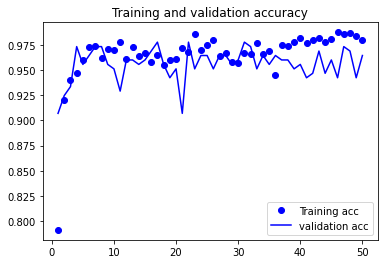

In [ ]:
# Plotting the results

import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title("Training and validation accuracy")
plt.legend()

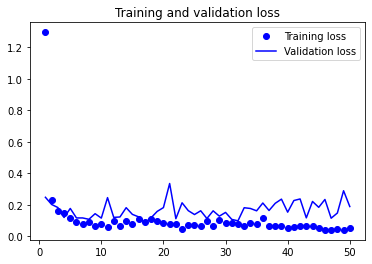

In [ ]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Feature Extraction With Data Augmentation

- It is much slower and more expensive, but it allows us to use data augmentation during training.
- extending the conv_base model and running it end to end on the inputs.

In [4]:
# Adding a densely conneected classifier on top of the convolutional base

from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(3, activation = "softmax"))

In [5]:
# >>> this is waht the model looks like

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 23,104,323
Trainable params: 23,104,323
Non-trainable params: 0
_________________________________________________________________


- Convolutional base of VGG16 has 14714688 parameters, which is very large.
- The classifier we are adding on top has 2 million parameters.

-------------------------------------------------------------------

- Before we compile and train the model, it is very important to freeze the convolutional base.
 - Freezing a layer or set of layers means preventing their weights from being updated during training.
 - If we don't do this, then the representation that were previously learned by the convolutional base will be modified during training.

 --------------------------------------------------------------------

 - In keras, we freeze a network by setting its trainable attribute to False

In [6]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [7]:
conv_base.trainable = False

In [8]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


- With this setup, only the weights from the two Dense layers that we added will be trained.
 - That's a total of four weight tensor: two per layer (the main weight matrix and the bias vector).

- if we ever modify weight trainability after compilation, we should then recompile the model, or these changes will be ignored.

In [9]:
import os

base_dir = "/content/drive/MyDrive/Potato-Disease-Classification/training/PlantVillageDir"
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

In [10]:
# Training the model end to end with a frozen convolutional base

from keras.preprocessing.image  import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256,256),
    batch_size=20,
    classes = ['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight'],
    class_mode = 'sparse')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(256,256),
    batch_size=20,
    classes = ['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight'],
    class_mode = 'sparse')


model.compile(optimizer="adam",
              loss = "sparse_categorical_crossentropy",
              metrics=["accuracy"])

Found 1710 images belonging to 3 classes.
Found 226 images belonging to 3 classes.


In [11]:
history = model.fit(
    train_generator, 
    steps_per_epoch=85,
    epochs = 30, 
    validation_data=validation_generator,
    validation_steps=11)

Epoch 1/30
85/85 [==============================] - 676s 8s/step - loss: 0.8698 - accuracy: 0.8089 - val_loss: 0.4063 - val_accuracy: 0.7955
Epoch 2/30
85/85 [==============================] - 32s 378ms/step - loss: 0.2661 - accuracy: 0.9018 - val_loss: 0.2617 - val_accuracy: 0.9000
Epoch 3/30
85/85 [==============================] - 32s 381ms/step - loss: 0.2521 - accuracy: 0.9041 - val_loss: 0.2327 - val_accuracy: 0.8909
Epoch 4/30
85/85 [==============================] - 32s 376ms/step - loss: 0.1940 - accuracy: 0.9213 - val_loss: 0.1924 - val_accuracy: 0.9182
Epoch 5/30
85/85 [==============================] - 32s 373ms/step - loss: 0.2043 - accuracy: 0.9296 - val_loss: 0.3385 - val_accuracy: 0.8773
Epoch 6/30
85/85 [==============================] - 32s 374ms/step - loss: 0.2073 - accuracy: 0.9225 - val_loss: 0.7775 - val_accuracy: 0.7591
Epoch 7/30
85/85 [==============================] - 33s 386ms/step - loss: 0.2220 - accuracy: 0.9178 - val_loss: 0.1296 - val_accuracy: 0.9409
E

In [15]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

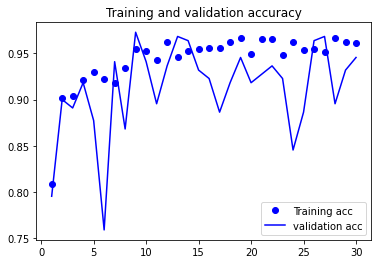

In [16]:
# Plotting the results

import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title("Training and validation accuracy")
plt.legend()

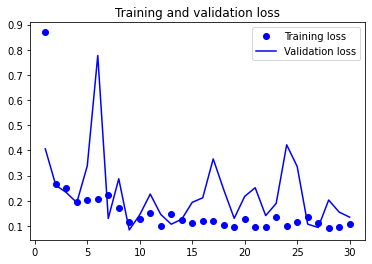

In [17]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    batch_size=20,
    classes = ['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight'],
    class_mode = 'sparse')

Found 226 images belonging to 3 classes.


In [13]:
test_loss, test_acc = model.evaluate(test_generator, steps = 11)

11/11 [==============================] - 49s 5s/step - loss: 0.2225 - accuracy: 0.9318


In [14]:
print("Test Acc:", test_acc)

Test Acc: 0.9318181872367859


# Fine Tuning Approach:
### We will be using Fine Tuning method for transfer learning

- Another widely used technique for model reuse, complementary to feature extraction, is fine-tuning.

- Fine-tuning consists of unfreezing a few of the top layers of a frozen model base, we used for feature extraction, and jointly training both the newly added part of the model(fully connected classifier) and these top layers.

- This is called fine-tuning because it slightly adjusts the more abstract representations of the model being reused, in order to make them relevant for the problem at hand.

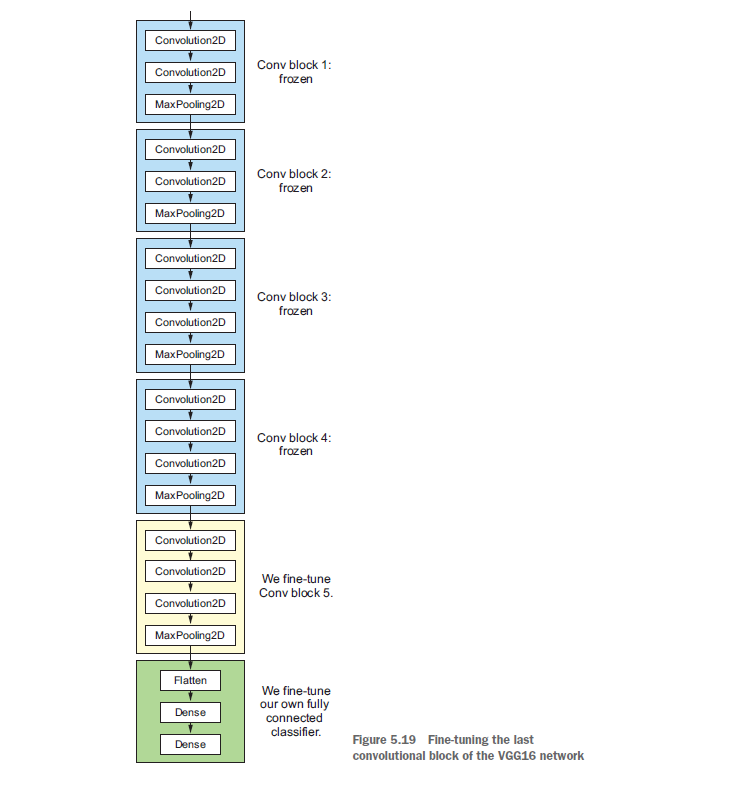

--------------------------------------------------------------------------------
- It is only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained.

- If the classifier isn't already trained, then the error signal propagating through the network during training will be too large, and the representations previoulsy learned by the layers being fine-tuned will be destroyed.

- The steps for fine-tuning a network are as follow:
 - 1. Add custom network on top of an already-trained base network.
 - 2. Freeze the base network
 - 3. Train the part we added
 - 4. Unfreeze some layers in the base network,
 - 5. Jointly train both these layers and the part we added.

 ###### We already completed the first three steps when doing feature extraction. Let's proceed with the step 4: We will unfreeze our conv_base and then freeze individual layers inside it.

In [18]:
# This is what our convolutional base looks like
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

- We will fine-tune the last three convolutional layers, which mean all layers up to block4_pool should be frozen, and the layers block5_conv1, block5_conv2 and block5_conv3 should be trainable.

### WHy not fine-tune more layers> Why not fine-tune the entire convolutional base?

- Earliers layers in the convolutional base encode more-genric, reusable features, whereas layers higher up encode more-specialized feature. It is more useful to fine-tune the more specialized features, because these are the ones that need to be repurposed on our new problem. There would be fast decreasing returns in fine-tuning lower layers.

- The more parameters we are training, the more we are at risk of overfitting.

- The convolutional base has 15 million paramters, so it would be risky to attempt to train it on our small dataset.


- Thus, in this situation, it is a good strategy to fine-tune only the top two or three layers in the convolutional base.

In [19]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

- Now we can begin fine-tuning the network. 

In [20]:
model.compile(optimizer="adam",
              loss = "sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [21]:
history = model.fit(
    train_generator, 
    steps_per_epoch=85,
    epochs = 30, 
    validation_data=validation_generator,
    validation_steps=11)

Epoch 1/30
85/85 [==============================] - 36s 397ms/step - loss: 2.0474 - accuracy: 0.4763 - val_loss: 0.9456 - val_accuracy: 0.4455
Epoch 2/30
85/85 [==============================] - 34s 394ms/step - loss: 0.8088 - accuracy: 0.5527 - val_loss: 0.6369 - val_accuracy: 0.7409
Epoch 3/30
85/85 [==============================] - 33s 387ms/step - loss: 0.5651 - accuracy: 0.8047 - val_loss: 0.5232 - val_accuracy: 0.8318
Epoch 4/30
85/85 [==============================] - 33s 383ms/step - loss: 0.3433 - accuracy: 0.8811 - val_loss: 0.3348 - val_accuracy: 0.8591
Epoch 5/30
85/85 [==============================] - 33s 384ms/step - loss: 0.3137 - accuracy: 0.9065 - val_loss: 0.3699 - val_accuracy: 0.8591
Epoch 6/30
85/85 [==============================] - 34s 395ms/step - loss: 0.9628 - accuracy: 0.8698 - val_loss: 0.5550 - val_accuracy: 0.8500
Epoch 7/30
85/85 [==============================] - 33s 387ms/step - loss: 0.3179 - accuracy: 0.8988 - val_loss: 0.5736 - val_accuracy: 0.8364

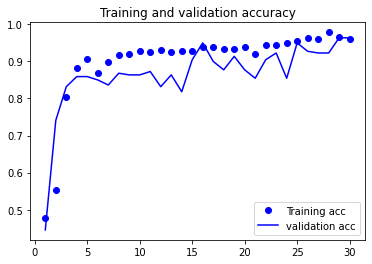

In [22]:
# Plotting the results

import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title("Training and validation accuracy")
plt.legend()

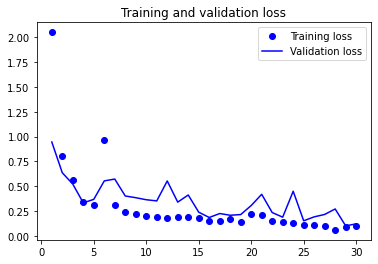

In [23]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

- These curves look noisy.
- To make them more readable, we can smooth them by replacing every loss and accuracy with exponential moving averages of these quantities.

In [41]:
def smooth_curve(points, factor= 0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

<Figure size 432x288 with 0 Axes>

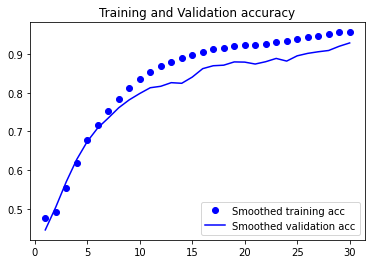

<Figure size 432x288 with 0 Axes>

In [44]:
plt.plot(epochs, smooth_curve(acc), 'bo', label = 'Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label = 'Smoothed validation acc')
plt.title("Training and Validation accuracy")
plt.legend()

plt.figure()

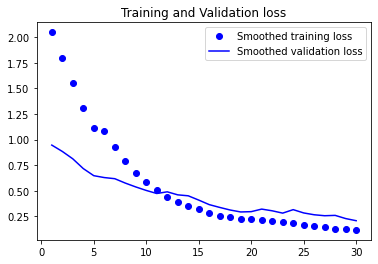

In [45]:
plt.plot(epochs, smooth_curve(loss), 'bo', label = 'Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label = 'Smoothed validation loss')
plt.title("Training and Validation loss")
plt.legend()

plt.show()

- We can now finally evaluate this model on the test data:

In [47]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    batch_size=20,
    classes = ['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight'],
    class_mode = 'sparse')

Found 226 images belonging to 3 classes.


In [48]:
test_loss, test_acc = model.evaluate(test_generator, steps = 11)

11/11 [==============================] - 2s 150ms/step - loss: 0.1732 - accuracy: 0.9455


In [49]:
print("test acc:", test_acc)

test acc: 0.9454545378684998


### Saving the Model


In [51]:
import os

In [69]:
work_dir = "/content/drive/MyDrive/Potato-Disease-Classification/training/"
os.chdir(work_dir)
os.getcwd()

'/content/drive/MyDrive/Potato-Disease-Classification/training'

In [71]:
model_version=max([int(i) for i in os.listdir("../transferLearningModels") + [0]])+1
model.save(f"../transferLearningModels/{model_version}")

### Wrapping up

- On a small dataset, overfitting will be the main issue. Data Augmentation is a powerful way to fight overfitting when we are working with image data.

- It is easy to reuse an existing convnet on a new dataste via feature extraction. This is a valuable technique for working with small image datasets.

- As a complement to feature extraction, we can use fine-tuning, which adapts to a new problem some of the representations previoulsy learned by an existing model. This pushes performance a bit further.